# Frequency Analysis

Run all cells in sequence. We first include the global analysis method from `Methods.py`, then 
generate $k$ (complex) sinusoids with random frequencies up to Nyquist, and then recover the frequencies
in two different ways:
1. We sum the sinusoids, form the delay-embedding, learn the $k$ complex-dimensional subspace of best fit
and compute the eigenvalues of the time-shift operator on that subspace. 
2. We orthogonalize the sinsuoid directly and compute the eigenvalues of time-shift.

In [1]:
from Methods import *
# from Includes import *
matplotlib.rcParams['figure.dpi'] = 150
%matplotlib inline

Original vectors & correlation
Orthogonal defect: 0.9929303873637657


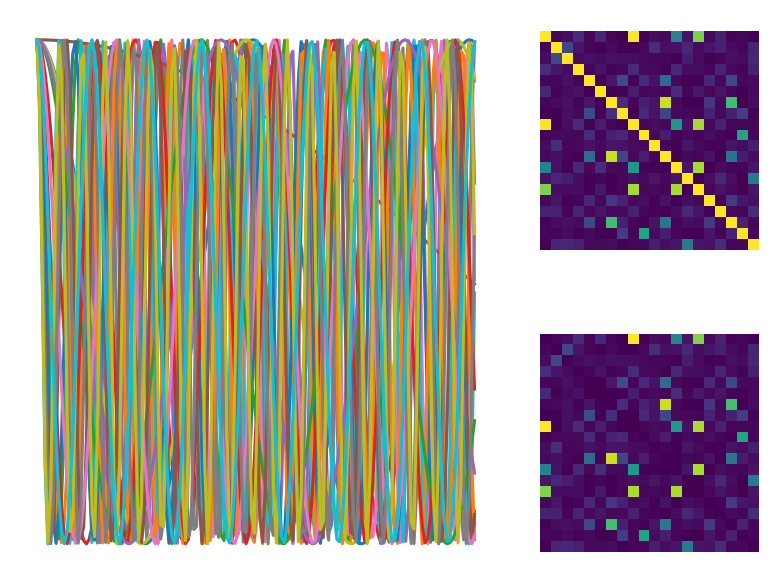

In [25]:
k = 20 # number of frequencies
SR = 48000 # sample rate
bandlimit = 8 # restrict frequencies to [0, SR / bandlimit]

fs = np.random.rand(k) * SR / bandlimit # generate random freqs

# N = bandlimit * k # set embedding dimension
N = k * bandlimit
# M = bandlimit * N # set dimension for extra rollover
M = 2 * N

phasor = 2 * np.pi * np.arange(0, M / SR, 1 / SR)
phases = np.array([phasor * f for f in fs])
source = np.exp(1j * phases)
vectors = source[:,:N]
vectors = (vectors.T / np.linalg.norm(vectors.T, axis=0)).T

print("Original vectors & correlation")
print("Orthogonal defect:", np.max(np.abs(np.conj(vectors) @ vectors.T - np.eye(k))))

fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 2, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)

ax1.plot(np.real(vectors.T[:]))
ax2.imshow(np.abs(np.conj(vectors) @ vectors.T))
ax3.imshow(np.abs(np.conj(vectors) @ vectors.T - np.eye(k)))

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

plt.show()

In [26]:
# synthetic estimate
B = vectors.T.copy()

Orthogonalized synthetic vectors
Orthogonal defect: 1.5543122426628286e-15


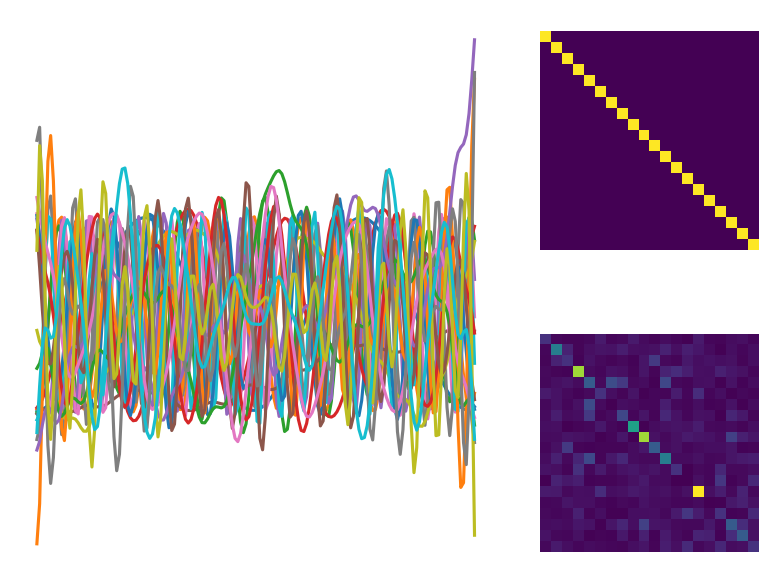

In [27]:
B = scipy.linalg.qr(B, mode = 'economic')[0]


fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 2, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)

ax1.plot(np.real(B[:]))
ax2.imshow(np.abs(np.conj(B.T) @ B))
ax3.imshow(np.abs(np.conj(B.T) @ B - np.eye(k)))

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

print("Orthogonalized synthetic vectors")
print("Orthogonal defect:", np.max(np.abs(np.conj(B.T) @ B - np.eye(k))))

plt.show()

In [28]:
# "observed", i.e. delay-embedded
coeffs = np.ones(k)
signal = source.T @ coeffs

trajectory, bases, distances, sep = analyze(signal, list(range(N)), k, alpha = 0.995, delta = 1, dtype = 'complex', randomize = True, mode = 'qr', corrected = True, normalize = False, pad = False)
A = np.conj(bases[-1])

100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:23<00:00,  6.88it/s]


In [29]:
length = 3
longphasor = 2 * np.pi * np.arange(0, length, 1 / SR)
multichannel = np.exp(1j * np.array([longphasor * f for f in fs]))
audio = np.real(np.sum(multichannel, axis = 0) / k)
ipd.Audio(audio, rate = SR)

Orthogonalized vectors learned from delay embedding
Projection defect: 1.3642420526593924e-12
Orthogonal defect: 8.881801730020287e-16


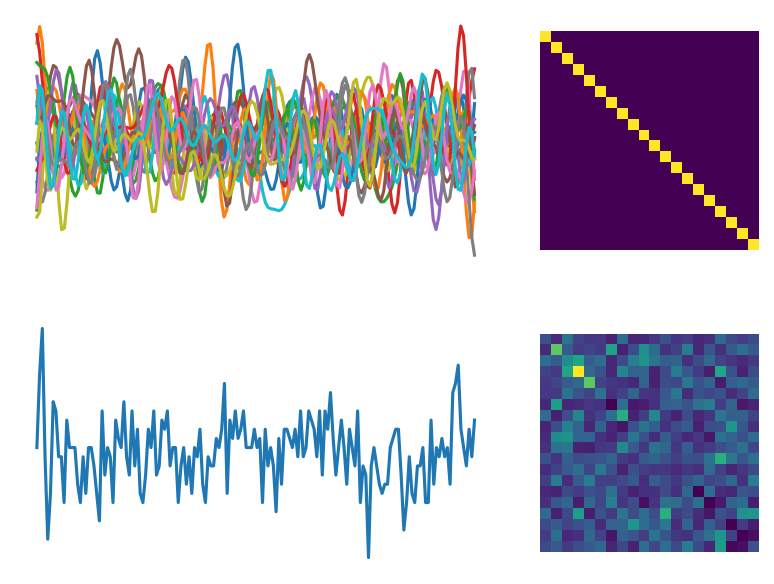

In [30]:
fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=2)

ax1.plot(np.real(A[:]))
ax2.imshow(np.abs(np.conj(A.T) @ A))
ax3.imshow(np.abs(np.conj(A.T) @ A - np.eye(k)))
ax4.plot(distances)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()

print("Orthogonalized vectors learned from delay embedding")
print("Projection defect:", distances[-1])
print("Orthogonal defect:", np.max(np.abs(np.conj(A.T) @ A - np.eye(k))))

plt.show()

In [31]:
print("Estimate from delay embedding and subspace learning:\n")

Z = A
S = np.linalg.inv(np.conj(Z[:-1,:].T) @ Z[:-1,:]) @ np.conj(Z[:-1,:].T) @ Z[1:,:]

omegas = np.linalg.eigvals(S)

freqs = np.sort([np.angle(o) * SR / (2 * np.pi) for o in omegas])[::-1]
fs = np.sort(fs)[::-1]

print("Detected:", freqs, "\n")

print("True:", fs, "\n")

# compute errors by comparing each estimated frequency from freqs
# to nearest element of the true frequencies, fs
errs = np.zeros(k)

for i,f in enumerate(freqs):
    a = np.argmin(np.abs(f - fs))
    errs[i] = f - fs[a]

print("Errors", errs, "\n")

magnitude = np.log(np.abs(errs[errs != 0]))
mean = np.mean(magnitude[magnitude != -np.inf]) if len(magnitude) else 0

# typical accuracy is has the average order of magnitude of error in frequency
print("Typical accuracy:", np.exp(mean),"Hz.\n", "Worst case:", np.max(np.abs(errs)),"Hz.\n", "Best case:", np.min(np.abs(errs)),"Hz.\n")

Estimate from delay embedding and subspace learning:

Detected: [5962.06837694 5800.13670148 5428.20948682 5186.16210186 4972.28866442
 4903.47556239 4767.04417352 4400.82500501 3490.52285349 3194.59200649
 2744.82562828 2408.85069677 2207.70058489 1673.10050838 1338.66346591
  804.37325458  717.81251525  630.49664018  610.80800744   74.00291538] 

True: [5962.06837694 5800.13670148 5428.20948682 5186.16210187 4972.28866444
 4903.47556245 4767.04417353 4400.82500501 3490.52285349 3194.59200649
 2744.82562828 2408.85069677 2207.70058489 1673.10050838 1338.66346591
  804.37325545  717.81250451  630.49661236  610.80801298   74.00291538] 

Errors [ 6.50288712e-10 -1.44063961e-09 -1.51703716e-09 -1.72058208e-08
 -1.85245881e-08 -6.27287591e-08 -4.76302375e-09 -7.98536348e-10
 -1.31876732e-10 -3.72892828e-11  8.82209861e-11 -3.66071617e-10
  1.86582838e-09 -3.74711817e-10  2.04863682e-10 -8.75106934e-07
  1.07359887e-05  2.78184305e-05 -5.54012240e-06  4.39783321e-10] 

Typical accuracy: 5.7

In [32]:
print("Synthetic estimate (from orthogonalizing sinusoids directly)\n")

Y = np.random.random((k,k)) + 1j * np.random.random((k, k))
Y = Y - np.conj(Y.T)
X = scipy.linalg.expm(Y)

# mix up by a random orthogonal matrix
Z = B @ X
S = np.linalg.inv(np.conj(Z[:-1,:].T) @ Z[:-1,:]) @ np.conj(Z[:-1,:].T) @ Z[1:,:]

omegas = np.linalg.eigvals(S)

freqs = np.sort([np.angle(o) * SR / (2 * np.pi) for o in omegas])
fs = np.sort(fs)

print("Detected:", freqs, "\n")

print("True:", fs, "\n")

# compute errors by comparing each estimated frequency from freqs
# to nearest element of the true frequencies, fs
errs = np.zeros(k)

for i,f in enumerate(freqs):
    a = np.argmin(np.abs(f - fs))
    errs[i] = f - fs[a]

print("Errors", errs, "\n")

magnitude = np.log(np.abs(errs[errs != 0]))
mean = np.mean(magnitude[magnitude != -np.inf]) if len(magnitude) else -np.inf

# typical accuracy is has the average order of magnitude of error in frequency
print("Typical accuracy:", np.exp(mean),"Hz.\n", "Worst case:", np.max(np.abs(errs)),"Hz.\n", "Best case:", np.min(np.abs(errs)),"Hz.\n")

Synthetic estimate (from orthogonalizing sinusoids directly)

Detected: [  74.00291538  610.80801298  630.49661236  717.81250451  804.37325545
 1338.66346591 1673.10050838 2207.70058489 2408.85069677 2744.82562828
 3194.59200649 3490.52285349 4400.82500501 4767.04417353 4903.47556245
 4972.28866444 5186.16210187 5428.20948682 5800.13670148 5962.06837694] 

True: [  74.00291538  610.80801298  630.49661236  717.81250451  804.37325545
 1338.66346591 1673.10050838 2207.70058489 2408.85069677 2744.82562828
 3194.59200649 3490.52285349 4400.82500501 4767.04417353 4903.47556245
 4972.28866444 5186.16210187 5428.20948682 5800.13670148 5962.06837694] 

Errors [ 5.95434813e-12  4.55429472e-10 -7.61133379e-10  2.40447662e-10
 -5.44559953e-11 -9.09494702e-13  2.27373675e-12  4.54747351e-12
  1.81898940e-12  0.00000000e+00 -2.27373675e-12  3.63797881e-12
 -4.54747351e-12 -4.82032192e-11  1.20962795e-10 -8.91304808e-11
  9.09494702e-12  1.00044417e-11  1.09139364e-11  7.27595761e-12] 

Typical accur